# BLACK-JACK problem

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

### Details:

Objective: obtain cards with the highest numerical value as possible without exceeding 21

- All face cards=10
- ace=1 or 11
- 2 cards delt to both dealer and player
- If player has 21 immediately= Natural, wins unless the dealer is also a natural
- if player does not have a natural, he can ask for more cards  one by one(HIT) untill he stops(STICKS). 
- sticks causes it to become the dealer's turn
- exceeding 21= BUST
- dealer hits/sticks without a choice= he mist stick on any sum >=17, and HIT otherwise.


BLACKJACK:
- MDP
- episodic
- rewards: 0,1,-1-> draw, winning, and loosing
- no discount here ($\gamma =1$)
- Cards are delt from an infinite deck. (with replacement)
- if player holds an ace that can be counted as an 11 without going BUST--> called a USABLE ace.
- player makes decisions based on: 
    a. his sum (12-21)
    b. dealer's card (one will always be shown)
    c. whether he has a usable ace.

Consider:
- POLICY: *stick if the player's sum is 20 or 21, otherwise always hit.*

In MONTE CARLO approach, we'd simulate as many black-jack games as possible using the given policy and then average the returns.

In [3]:
# THE CONSTANTANTS:

HIT=0
STICK=1 # or stand
ACTIONS=[HIT, STICK]


In [4]:
#POLICY:
POLICY=np.zeros(22,dtype=np.int)
for i in range(12,20, 1):
    POLICY[i]=HIT
POLICY[20]=STICK
POLICY[21]=STICK

/tmp/ipykernel_20572/2396012759.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  POLICY=np.zeros(22,dtype=np.int)


In [5]:
#function for the decisions that the player should make:
def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY[player_sum]


In [6]:
#the action that the player will take: HIT or STICK based on whether the he has a natural or not 
def action_player(usable_ace_player, player_sum, dealer_card):
    if np.random.binomial(1,0.5)==1:
        return STICK
    return HIT

In [7]:
#dealer's policy:
POLICY_DEALER=np.zeros(22)
for i in range(12,17):
    POLICY_DEALER[i]=HIT
for i in range(17,22):
    POLICY_DEALER[i]=STICK

In [8]:
#getting new card:
def get_card():
    card=np.random.randint(1,14) #there are 13 cards in total (1-13)
    card=min(card,10)
    return card

# value of the card:
def card_val(card_id):
    return 11 if card_id==1 else card_id


Playing a game:

In [9]:
def playing_game(policy_player, initial_state=None,initial_action=None):  #state is whether the player has a usable ace or not
    player_sum=0 # the player does not have any card when the game starts
    player_trajectory=[] #he hasn't started planning out how to play the game yet
    usable_ace_player=False  #we're setting it so that the player does not use any ace at the beginning as 11
    
    #dealer's cards:
    dealer_card1=0
    dealer_card2=0
    usable_ace_dealer=False 

    if initial_state is None:
        while player_sum<12: #always hit
            card=get_card()
            player_sum+=card_val(card)

            if player_sum>21: #1-2 aces
                player_sum-=10 #last card is ace(assuming since we've not given him an ace at the beginning)
            else:
                usable_ace_player |= (1==card)   # union operation
        
        #dealer initialization: he shows the first card he has:
        dealer_card1=get_card()
        dealer_card2=get_card()

    else:
        usable_ace_player,player_sum, dealer_card1=initial_state
        dealer_card2=get_card()
        
    state=[usable_ace_player, player_sum, dealer_card1] #initial state of the game

    dealer_sum=card_val(dealer_card1)+card_val(dealer_card2)
    usable_ace_dealer=1 in (dealer_card1,dealer_card2)
    
    #if the dealer has more than 21 as the sum (same logic as for the player)
    if dealer_sum > 21:
        assert dealer_sum == 22
        # use one Ace as 1 rather than 11
        dealer_sum -= 10

    #starting the game:
    while True:
        if initial_action is not None:
            action=initial_action
            initial_action=None
        else:
            #action will be based on the sum of the player's sum of the cards he holds
            action=action_player(usable_ace_player, player_sum, dealer_card1)
        
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action==STICK:
            break
        
        card=get_card()
        ace_count=int(usable_ace_player)  #count of the number of aces that the player has
        if card==1:
            ace_count+=1
        player_sum+=card_val(card)

        # If the player has a usable ace, use it as 1 to avoid busting and continue.
        while player_sum > 21 and ace_count:
            player_sum -= 10
            ace_count -= 1
        # player busts
        if player_sum > 21:
            return state, -1, player_trajectory
        assert player_sum <= 21
        usable_ace_player = (ace_count == 1)

        while True:
        # get action based on current sum
            # get action based on current sum
            action = POLICY_DEALER[dealer_sum]
            if action == STICK:
                break
            # if hit, get a new card
            new_card = get_card()
            ace_count = int(usable_ace_dealer)
            if new_card == 1:
                ace_count += 1
            dealer_sum += card_val(new_card)
            # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
            while dealer_sum > 21 and ace_count:
                dealer_sum -= 10
                ace_count -= 1
            # dealer busts
            if dealer_sum > 21:
                return state, 1, player_trajectory
            usable_ace_dealer = (ace_count == 1)

    if player_sum>dealer_sum:
        return state, 1, player_trajectory
    elif player_sum==dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory

MC with Exploring starts:

With respect to blackjack:
- picks the dealer’s cards, the player’s sum, and whether or not the player has a usable ace, all at random with equal probability.
- the initial policy we use the policy evaluated in the previous blackjack example, that which sticks only on 20 or 21.
- The initial action-value function can be zero for all state–action pairs.

In [10]:
def MC_ES(episodes):
    q=np.zeros((10,10,2,2))  #state action value: player_sum, dealer_card, usable_ace, action
    q_count=np.ones((10,10,2,2))  #we used ones to avoif division with 0

    #applying the greedy policy to it:
    def greedy_policy(usable_ace, player_sum, dealer_card):
        usable_ace=int(usable_ace)
        player_sum-=12
        dealer_card-=1
        values_=q[player_sum, usable_ace, dealer_card,:]/ q_count[player_sum, usable_ace, dealer_card, :]  #Average returns
        return np.random.choice([action_ for action_,value_ in enumerate(values_) if value_== np.max(values_)])

    #episodes (more than 2):
    for episode in tqdm(range(episodes)):
        initial_state=[bool(np.random.choice([0, 1])),np.random.choice(range(12, 22)), np.random.choice(range(1, 11))] #randomly initialised state
        initial_action=np.random.choice(ACTIONS)
        curr_pol=greedy_policy if episode else target_policy_player
        _, reward, trajectory=playing_game(curr_pol, initial_state, initial_action)
        first_visit=set()  #setting a new iterable object
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            usable_ace=int(usable_ace)
            player_sum-=12
            dealer_card-=1
            state_action=(usable_ace, player_sum, dealer_card, action)
            if state_action in first_visit:
                continue
            first_visit.add(state_action)
             # update values of state-action pairs
            q[player_sum, dealer_card, usable_ace, action] += reward
            q_count[player_sum, dealer_card, usable_ace, action] +=1
    return q/q_count

In [11]:

def figure_5_2():
    state_action_values = MC_ES(500000)

    state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
    state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

    # get the optimal policy
    action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
    action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

    images = [action_usable_ace,
              state_value_usable_ace,
              action_no_usable_ace,
              state_value_no_usable_ace]

    titles = ['Optimal policy with usable Ace',
              'Optimal value with usable Ace',
              'Optimal policy without usable Ace',
              'Optimal value without usable Ace']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for image, title, axis in zip(images, titles, axes):
        fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)

    plt.savefig('Probabilites_BlackJack')
    plt.show()

100%|██████████| 500000/500000 [00:22<00:00, 21787.53it/s]


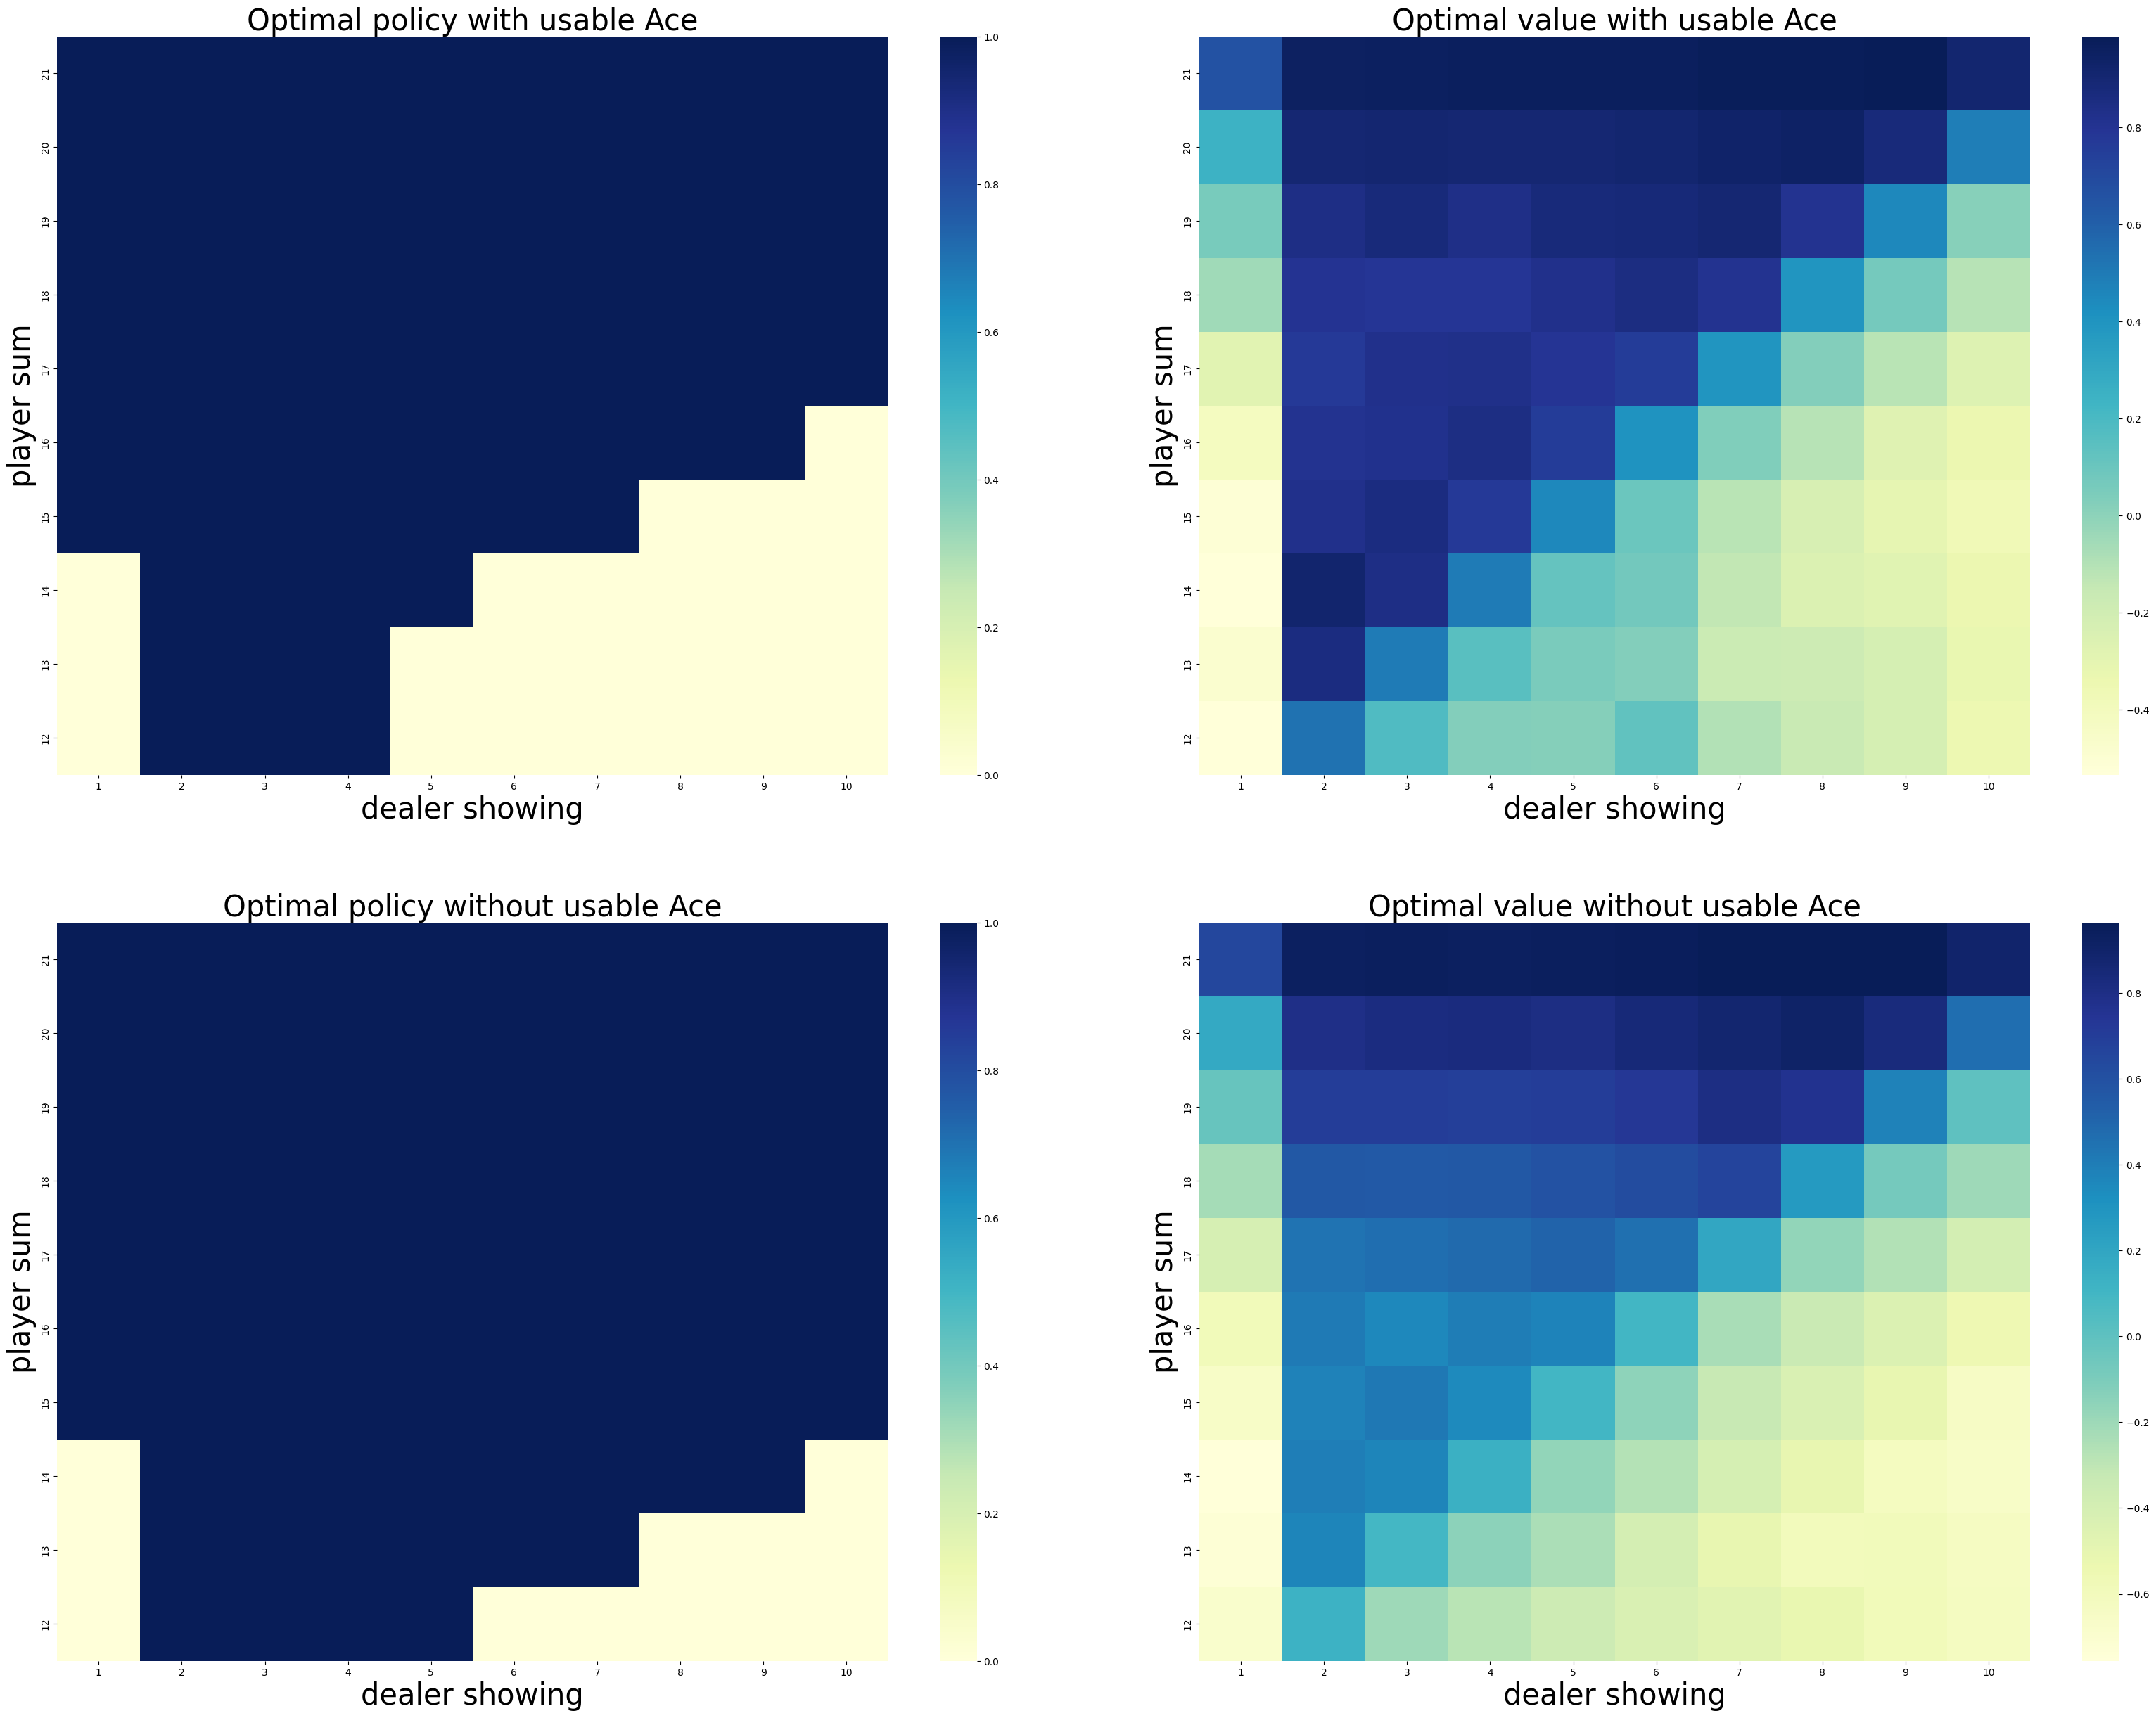

In [12]:
if __name__ == '__main__':
    figure_5_2()